In [6]:
import os
import json
from tqdm import tqdm
from glob import glob
import numpy as np

import avstack
import avapi

path_to_results = "../../../../outputs/last_run"

In [7]:
# Load in the metadata
with open(os.path.join(path_to_results, "launch_metadata.json"), 'r') as f:
    launch_metadata = json.load(f)
with open(os.path.join(path_to_results, "simulator", "metadata.json"), "r") as f:
    sim_metadata = json.load(f)

# Set up the carla dataset manager
CSM = avapi.carla.CarlaScenesManager(data_dir=sim_metadata["dataset_path"])
CDM = CSM.get_scene_dataset_by_index(sim_metadata["scene_idx"])
all_ts = np.array(CDM.timestamps)

# Get the frame/time mappings
with open(os.path.join(path_to_results, "simulator", "idx_to_frame_map.txt"), "r") as f:
    idx_to_frame_map = {int(line.rstrip().split()[0]): int(line.rstrip().split()[1]) for line in f.readlines()}
frame_to_idx_map = {v:k for k, v in idx_to_frame_map.items()}

# Load in the agent paths
output_paths = {}
frame_to_output_index = {}
for agent in ["ego", "command_center"] + [f"agent{i}" for i in range(1, 1+launch_metadata["n_infrastructure_agents"])]:
    output_paths[agent] = {}
    frame_to_output_index[agent] = {}
    for subfolder in ["detections", "tracks"]:
        path_to_sub = os.path.join(path_to_results, agent, subfolder)
        files_in_folder = [os.path.basename(file) for file in sorted(glob(os.path.join(path_to_sub, "*.txt")))]
        output_paths[agent][subfolder] = {}
        frame_to_output_index[agent][subfolder] = {}
        for i, file in enumerate(files_in_folder):
            ts = float(file.split('-')[3].replace('.txt', ''))
            frame = CDM.frames[np.argmin(abs(all_ts - ts))]
            idx = frame_to_idx_map[frame]
            output_paths[agent][subfolder][i] = {
                "timestamp":ts,
                "idx": idx,
                "frame": frame,
                "path": os.path.join(path_to_sub, file)
            }
            frame_to_output_index[agent][subfolder][frame] = i
        print("Recognized {} files for agent {} in subfolder {}".format(len(files_in_folder), agent, subfolder))

Recognized 58 files for agent ego in subfolder detections
Recognized 58 files for agent ego in subfolder tracks
Recognized 0 files for agent command_center in subfolder detections
Recognized 58 files for agent command_center in subfolder tracks
Recognized 58 files for agent agent1 in subfolder detections
Recognized 58 files for agent agent1 in subfolder tracks
Recognized 58 files for agent agent2 in subfolder detections
Recognized 58 files for agent agent2 in subfolder tracks
Recognized 58 files for agent agent3 in subfolder detections
Recognized 58 files for agent agent3 in subfolder tracks
Recognized 58 files for agent agent4 in subfolder detections
Recognized 58 files for agent agent4 in subfolder tracks


In [8]:
def _get_base(agent, frame, subfolder, decoder):
    # load up the tracks
    index = frame_to_output_index[agent][subfolder][frame]
    file = output_paths[agent][subfolder][index]["path"]
    with open(file, "rb") as f:
        objects = json.load(f, cls=decoder)

    # replace passive reference with active
    for obj in objects:
        if isinstance(obj.reference, avstack.geometry.PassiveReferenceFrame):
            if obj.reference.frame_id == "ego":
                reference = CDM.get_ego_reference(frame)
            elif "agent" in obj.reference.frame_id:
                sensor = get_lidar_sensor(agent)
                reference = CDM.get_calibration(frame, sensor=sensor).reference
            elif obj.reference.frame_id == "world":
                reference = avstack.geometry.GlobalOrigin3D
            else:
                raise NotImplementedError(obj.reference.frame_id)
            if agent == "command_center":
                obj.state.reference = reference
                obj.state.where_is_t = "bottom"
                obj.state.q.reference = reference
            else:
                if hasattr(obj, "q"):  # HACK for tracks
                    obj.reference = reference
                    obj.where_is_t = "bottom"
                    obj.q.reference = reference
                else:  # HACK for detections
                    obj.box.where_is_t = "bottom"
                    obj.box.position.reference = reference
                    obj.box.attitude.reference = reference

    return objects


def get_detections(agent, frame):
    return _get_base(agent, frame, "detections", avstack.modules.perception.detections.DetectionContainerDecoder)


def get_tracks(agent, frame):
    return _get_base(agent, frame, "tracks", avstack.modules.tracking.tracks.TrackContainerDecoder)


def get_camera_sensor(agent):
    return _get_sensor(agent, "camera")


def get_lidar_sensor(agent):
    return _get_sensor(agent, "lidar")


def _get_sensor(agent, sensor_type):
    if agent == "ego":
        sensor = "main_{}".format(sensor_type)
    elif "agent" in agent:
        if sensor_type == "camera":
            prefix = "CAM"
        else:
            prefix = "LIDAR"
        sensor = "{}_INFRASTRUCTURE_{:03d}".format(prefix, int(agent.replace("agent","")))
    else:
        raise NotImplementedError(agent)
    return sensor

## Visualize output information

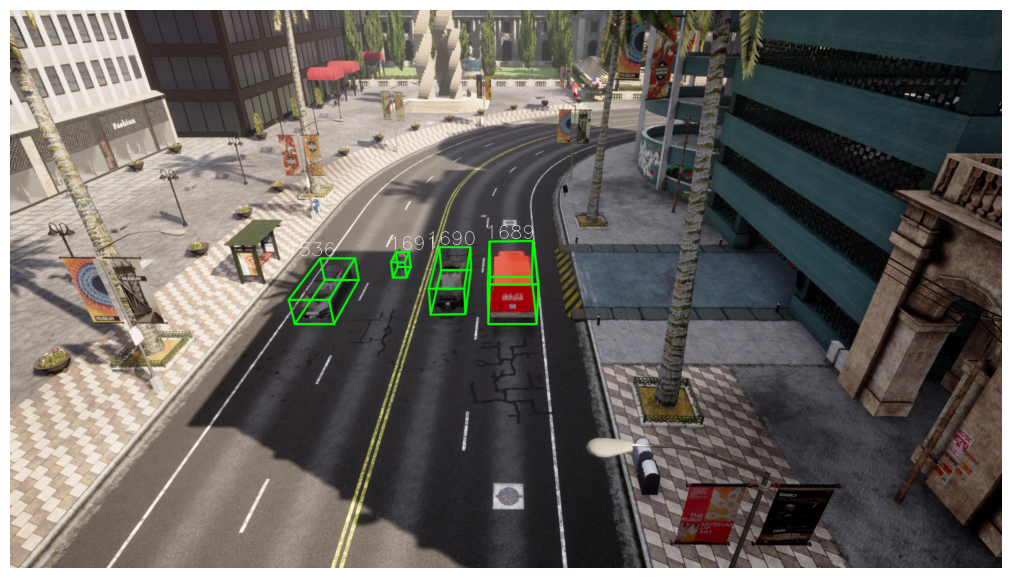

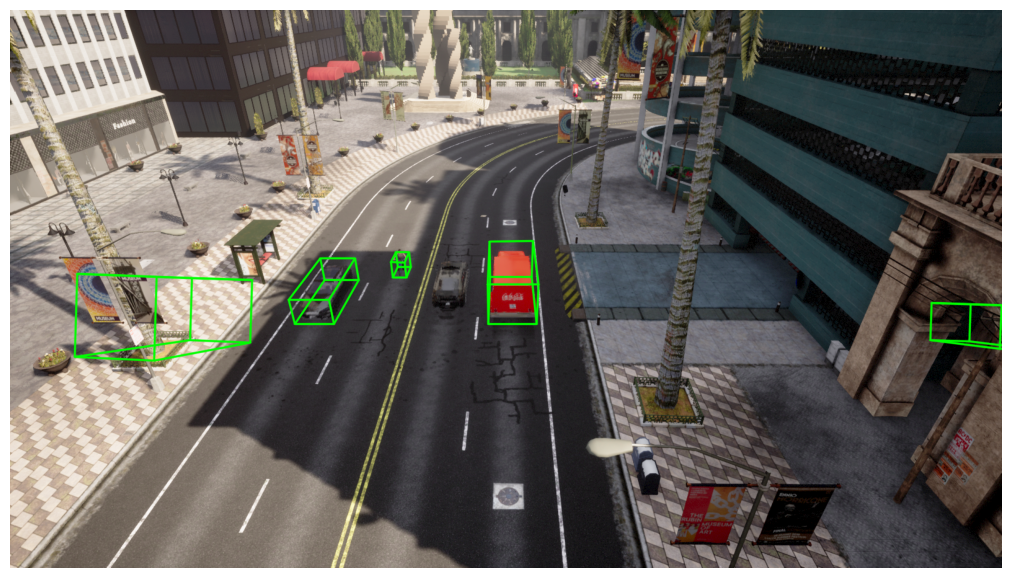

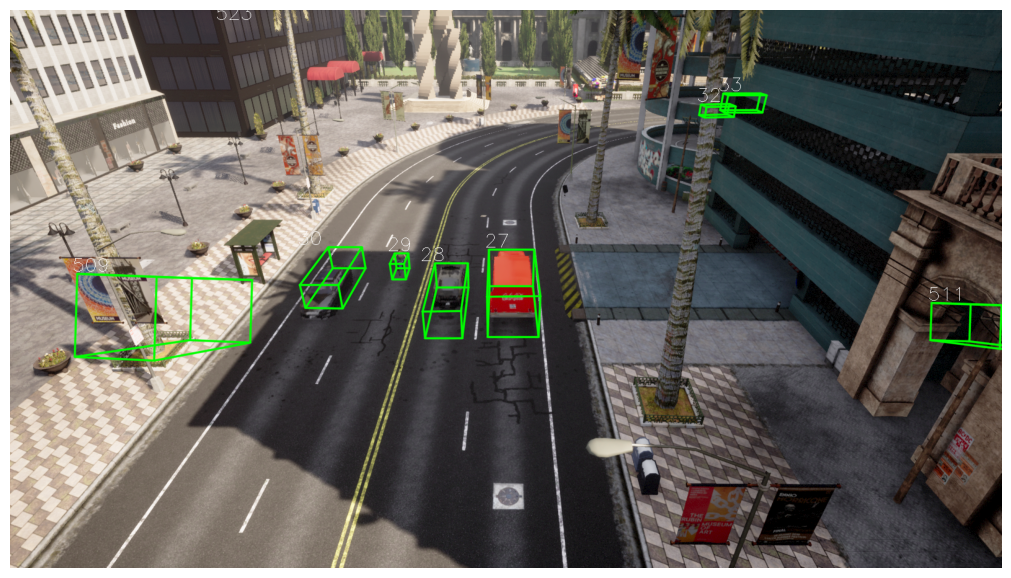

In [13]:
agent = "agent2"
sensor = get_camera_sensor(agent)
idx_frame = 22
frame = CDM.get_frames(sensor=sensor)[idx_frame]
img = CDM.get_image(frame=frame, sensor=sensor)
detections = get_detections(agent=agent, frame=frame)
tracks = get_tracks(agent=agent, frame=frame)
tracks = get_tracks(agent="command_center", frame=frame)
objects = CDM.get_objects(frame=frame, sensor=get_camera_sensor(agent))

# visualize snapshot
avapi.visualize.snapshot.show_image_with_boxes(img, objects, inline=True)
avapi.visualize.snapshot.show_image_with_boxes(img, detections, inline=True)
avapi.visualize.snapshot.show_image_with_boxes(img, tracks, inline=True)

In [ ]:
# make movie
frames = list(frame_to_output_index[agent]["tracks"].keys())[:-2]
print("loading frames")
all_imgs = [CDM.get_image(frame=frame, sensor="main_camera") for frame in tqdm(frames)]
print("loading tracks")
all_tracks = [get_tracks(agent="ego", frame=frame) for frame in tqdm(frames)]
avapi.visualize.movie.make_movie(
    raw_imgs=all_imgs, boxes=all_tracks, save=True, name="ego_playback.mov", show_in_notebook=True
)